# Project 2: Wrangling and Analyze WeRateDogs Data



Libraries needed for this project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tweepy
import json
import re
import time
from nltk import pos_tag


In [2]:
# Tweepy keys and token

consumer_key = 'UBG2RV1SOsPGdzuLHPldToxH3'
consumer_secret = 'KIdCRKbQI0FYRCwZxackWybYRVxI0GQxYhyAjrbnRsQWh21BJo'
access_token = '251447508-y2Qnf9jyv0dRlnHrbRgtN1zG7cIl4KdTCdfghoJ6'
access_secret = '5srICytXtcOmm0HKJlJqus0tERElTVV8fN5Q3QduSsyq0'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [3]:
# Supplied file
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv',encoding='utf-8')

In [4]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [5]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [6]:
# Requesting tweet image predictions
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

with open('image_predictions.tsv' , 'wb') as file:
    image_predictions = requests.get(url, auth=('user', 'pass'))
    file.write(image_predictions.content)    

In [7]:
# Reading image predictions
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t',encoding='utf-8')

In [8]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [9]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [10]:
### this code for bring tweets from json file but becasues it need privte secure key i uploaded tweet_json file instead of that
#collect Tweepy status object based on Tweet ID and store in list
tweets_found = []

# Tweets that can't be found are saved in the list below:
tweets_not_found = []

with open('tweet_json.txt', 'w') as file:
    for tweet_id in list(twitter_archive.tweet_id):
        try:
            tweet_status = api.get_status(tweet_id,tweet_mode='extended')
            json.dump(tweet_status._json, file)
            file.write('\n')
            tweets_found.append(tweet_id)
        except Exception as e:
            tweets_not_found.append(tweet_id)
    

Rate limit reached. Sleeping for: 745
Rate limit reached. Sleeping for: 745


In [23]:
#Reading JSON content as pandas dataframe
tweet_json = pd.read_json('tweet_json.txt', lines = True,encoding='utf-8')
tweet_json.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",33700,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,NaN,NaN,NaN,NaN,6970,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",29229,False,This is Tilly. She's just checking pup on you....,NaN,...,NaN,NaN,NaN,NaN,5273,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",21976,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,NaN,NaN,NaN,NaN,3464,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",36795,False,This is Darla. She commenced a snooze mid meal...,NaN,...,NaN,NaN,NaN,NaN,7193,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",35188,False,This is Franklin. He would like you to stop ca...,NaN,...,NaN,NaN,NaN,NaN,7718,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [24]:
# Reading gathered files
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')
tweet_json = pd.read_json('tweet_json.txt', lines = True,encoding='utf-8')

In [25]:
#view dataset
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [26]:
#get information about the dataset
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [27]:
#missing values in each column of twitter_archive dataset
twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [28]:
#unique rating_numerator 
twitter_archive['rating_numerator'].unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [29]:
twitter_archive[twitter_archive['rating_denominator'] > 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None


In [30]:
#rows with rating numerator greater than 10
twitter_archive[twitter_archive['rating_numerator'] > 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [31]:
#number of records with rating numerator greater than 10
len(twitter_archive[twitter_archive['rating_numerator'] > 10])

1455

In [32]:
#rows with rating numerator greater than 20
twitter_archive[twitter_archive['rating_numerator'] > 20]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [33]:
#records with rating numerator greater than 20
len(twitter_archive[twitter_archive['rating_numerator'] > 20])

24

In [34]:
#rows with rating numerator equal to 0
twitter_archive[twitter_archive['rating_numerator'] == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


In [35]:
#records with rating numerator greater than 0
len(twitter_archive[twitter_archive['rating_numerator'] == 0])

2

In [36]:
twitter_archive_over_20 = twitter_archive[twitter_archive['rating_numerator'] > 20]
twitter_archive_over_20['rating_denominator'].unique()

array([ 10,   0,  70,   7, 150, 170,  50,  90,  80,  40, 130, 110, 120])

In [37]:
twitter_archive_over_20['rating_numerator'].unique()

array([ 420,  666,  182,  960,   75,   84,   24,   27,  165, 1776,  204,
         50,   99,   80,   45,   60,   44,  143,  121,   26,  144,   88])

Investigating the rating_denominator for twitter_archive_over_20. 

In [45]:
#divide the numerator and denominator by 7 to retain a denominator of 10
twitter_archive_over_20[twitter_archive_over_20['rating_denominator'] == 70]



,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None


In [46]:
#divide the numerator and denominator by 15 to retain a denominator of 10
twitter_archive_over_20[twitter_archive_over_20['rating_denominator'] == 150]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [47]:
#divide the numerator and denominator by 17 to retain a denominator of 10
twitter_archive_over_20[twitter_archive_over_20['rating_denominator'] == 170]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None


In [49]:
#divide the numerator and denominator by 9 to retain a denominator of 10
twitter_archive_over_20[twitter_archive_over_20['rating_denominator'] == 90]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None


In [50]:
#divide the numerator and denominator by 8 to retain a denominator of 10
twitter_archive_over_20[twitter_archive_over_20['rating_denominator'] == 80]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
1843,675853064436391936,NaN,NaN,2015-12-13 01:41:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have an entire platoon of puppers. Tot...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675853064...,88,80,None,None,None,None,None


In [51]:
#divide the numerator and denominator by 4 to retain a denominator of 10
twitter_archive_over_20[twitter_archive_over_20['rating_denominator'] == 40]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1433,697463031882764288,NaN,NaN,2016-02-10 16:51:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Wednesday here's a bucket of pups. 44/40...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697463031...,44,40,None,None,None,None,None


In [52]:
#divide the numerator and denominator by 13 to retain a denominator of 10
twitter_archive_over_20[twitter_archive_over_20['rating_denominator'] == 130]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1634,684225744407494656,6.842229e+17,4.196984e+09,2016-01-05 04:11:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Two sneaky puppers were not initially seen, mo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684225744...,143,130,None,None,None,None,None


In [53]:
#divide the numerator and denominator by 11 to retain a denominator of 10
twitter_archive_over_20[twitter_archive_over_20['rating_denominator'] == 110]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1635,684222868335505415,NaN,NaN,2016-01-05 04:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Someone help the girl is being mugged. Several...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684222868...,121,110,None,None,None,None,None


In [54]:
#divide the numerator and denominator by 12 to retain a denominator of 10
twitter_archive_over_20[twitter_archive_over_20['rating_denominator'] == 120]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1779,677716515794329600,NaN,NaN,2015-12-18 05:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",IT'S PUPPERGEDDON. Total of 144/120 ...I think...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677716515...,144,120,None,None,None,None,None


In [55]:
#divide the numerator and denominator by 5 to retain a denominator of 10
twitter_archive_over_20[twitter_archive_over_20['rating_denominator'] == 50]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845...,60,50,a,None,None,None,None


In [57]:
#sorted name column unique variables from the twitter_archive to see how the dogs have been named
sorted(twitter_archive['name'].unique())

['Abby',
 'Ace',
 'Acro',
 'Adele',
 'Aiden',
 'Aja',
 'Akumi',
 'Al',
 'Albert',
 'Albus',
 'Aldrick',
 'Alejandro',
 'Alexander',
 'Alexanderson',
 'Alf',
 'Alfie',
 'Alfy',
 'Alice',
 'Amber',
 'Ambrose',
 'Amy',
 'Amélie',
 'Anakin',
 'Andru',
 'Andy',
 'Angel',
 'Anna',
 'Anthony',
 'Antony',
 'Apollo',
 'Aqua',
 'Archie',
 'Arlen',
 'Arlo',
 'Arnie',
 'Arnold',
 'Arya',
 'Ash',
 'Asher',
 'Ashleigh',
 'Aspen',
 'Astrid',
 'Atlas',
 'Atticus',
 'Aubie',
 'Augie',
 'Autumn',
 'Ava',
 'Axel',
 'Bailey',
 'Baloo',
 'Balto',
 'Banditt',
 'Banjo',
 'Barclay',
 'Barney',
 'Baron',
 'Barry',
 'Batdog',
 'Bauer',
 'Baxter',
 'Bayley',
 'BeBe',
 'Bear',
 'Beau',
 'Beckham',
 'Beebop',
 'Beemo',
 'Bell',
 'Bella',
 'Belle',
 'Ben',
 'Benedict',
 'Benji',
 'Benny',
 'Bentley',
 'Berb',
 'Berkeley',
 'Bernie',
 'Bert',
 'Bertson',
 'Betty',
 'Beya',
 'Biden',
 'Bilbo',
 'Billl',
 'Billy',
 'Binky',
 'Birf',
 'Bisquick',
 'Blakely',
 'Blanket',
 'Blipson',
 'Blitz',
 'Bloo',
 'Bloop',
 'Blu',


In [58]:
twitter_archive.query('name == "None"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,19607400.0,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
37,885167619883638784,NaN,NaN,2017-07-12 16:03:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a corgi undercover as a malamute....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885167619...,13,10,None,None,None,None,None
41,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,14,10,None,None,None,None,None


In [59]:
len(twitter_archive[twitter_archive['name'] == 'None'])

745

In [60]:
#view images dataset
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [61]:
#structure of the images dataset
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [62]:
#investigate mising data
image_predictions.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [63]:
#summarize numerical columns
#tweet_id was summarized too,this column should be changed to object
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [64]:
#length of unique urls
len(image_predictions['jpg_url'].unique())

2009

In [65]:
#duplicated url (sanity check)
len(image_predictions[image_predictions['jpg_url'].duplicated()])

66

In [66]:
#dog breeds in p1 column, check for all lengths
filter_p1 = image_predictions.groupby(['p1']).filter(lambda x: len(x) == 3)
filter_p1['p1'].value_counts()

curly-coated_retriever        3
motor_scooter                 3
briard                        3
cairn                         3
Welsh_springer_spaniel        3
window_shade                  3
seashore                      3
ski_mask                      3
comic_book                    3
muzzle                        3
common_iguana                 3
Greater_Swiss_Mountain_dog    3
refrigerator                  3
Arabian_camel                 3
dishwasher                    3
Christmas_stocking            3
Irish_water_spaniel           3
prison                        3
sea_lion                      3
giant_schnauzer               3
vacuum                        3
space_heater                  3
white_wolf                    3
Leonberg                      3
Scottish_deerhound            3
stone_wall                    3
Brabancon_griffon             3
Ibizan_hound                  3
washbasin                     3
mousetrap                     3
triceratops                   3
cowboy_h

In [67]:
len(image_predictions[image_predictions['p1_conf'] > 0.5])

1239

In [68]:
len(image_predictions[image_predictions['p2_conf'] > 0.5])

0

In [69]:
len(image_predictions[image_predictions['p3_conf'] > 0.5])

0

In [70]:
tweet_json

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",33700,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,NaN,NaN,NaN,NaN,6970,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",29229,False,This is Tilly. She's just checking pup on you....,NaN,...,NaN,NaN,NaN,NaN,5273,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",21976,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,NaN,NaN,NaN,NaN,3464,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",36795,False,This is Darla. She commenced a snooze mid meal...,NaN,...,NaN,NaN,NaN,NaN,7193,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",35188,False,This is Franklin. He would like you to stop ca...,NaN,...,NaN,NaN,NaN,NaN,7718,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",17752,False,Here we have a majestic great white breaching ...,NaN,...,NaN,NaN,NaN,NaN,2586,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",10335,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,NaN,NaN,NaN,NaN,1647,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56678,False,When you watch your owner call another dog a g...,NaN,...,NaN,NaN,NaN,NaN,15684,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",24433,False,This is Zoey. She doesn't want to be one of th...,NaN,...,NaN,NaN,NaN,NaN,3604,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",27854,False,This is Cassie. She is a college pup. Studying...,NaN,...,NaN,NaN,NaN,NaN,6070,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [71]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2325 non-null datetime64[ns]
display_text_range               2325 non-null object
entities                         2325 non-null object
extended_entities                2055 non-null object
favorite_count                   2325 non-null int64
favorited                        2325 non-null bool
full_text                        2325 non-null object
geo                              0 non-null float64
id                               2325 non-null int64
id_str                           2325 non-null int64
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null float64
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 n

In [72]:
tweet_json.describe()

,contributors,coordinates,favorite_count,geo,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str,retweet_count
count,0.0,0.0,2325.000000,0.0,2.325000e+03,2.325000e+03,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,2193.0,2193.0,2.600000e+01,2.600000e+01,2325.000000
mean,NaN,NaN,7028.679570,NaN,7.418346e+17,7.418346e+17,7.440692e+17,7.440692e+17,2.040329e+16,2.040329e+16,0.0,0.0,8.113972e+17,8.113972e+17,2459.304516
std,NaN,NaN,10924.795649,NaN,6.822081e+16,6.822081e+16,7.524295e+16,7.524295e+16,1.260797e+17,1.260797e+17,0.0,0.0,6.295843e+16,6.295843e+16,4165.935740
min,NaN,NaN,0.000000,NaN,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,0.0,0.0,6.721083e+17,6.721083e+17,1.000000
25%,NaN,NaN,1224.000000,NaN,6.782555e+17,6.782555e+17,6.757073e+17,6.757073e+17,3.589728e+08,3.589728e+08,0.0,0.0,7.761338e+17,7.761338e+17,493.000000
50%,NaN,NaN,3037.000000,NaN,7.182346e+17,7.182346e+17,7.032559e+17,7.032559e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.281173e+17,8.281173e+17,1144.000000
75%,NaN,NaN,8554.000000,NaN,7.986654e+17,7.986654e+17,8.233264e+17,8.233264e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.637581e+17,8.637581e+17,2840.000000
max,NaN,NaN,144274.000000,NaN,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,0.0,0.0,8.860534e+17,8.860534e+17,70345.000000


In [73]:
tweet_json.isnull().sum()

contributors                     2325
coordinates                      2325
created_at                          0
display_text_range                  0
entities                            0
extended_entities                 270
favorite_count                      0
favorited                           0
full_text                           0
geo                              2325
id                                  0
id_str                              0
in_reply_to_screen_name          2248
in_reply_to_status_id            2248
in_reply_to_status_id_str        2248
in_reply_to_user_id              2248
in_reply_to_user_id_str          2248
is_quote_status                     0
lang                                0
place                            2324
possibly_sensitive                132
possibly_sensitive_appealable     132
quoted_status                    2301
quoted_status_id                 2299
quoted_status_id_str             2299
quoted_status_permalink          2299
retweet_coun

In [74]:
len(tweet_json[tweet_json['id'].duplicated()])

0

### Quality issues
#### A. twitter_archive
1.Missing values<br>
>i) in_reply_to_status_id and in_reply_to_user_id have 2278 missing values each,<br><br>
>ii) retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp have 2175 missing values each and <br><br>
>iii) expanded_urls has 59 missing values.

2.in_reply_to_status_id,in_reply_to_user_id, retweeted_status_id and retweeted_status_user_id are floats instead of integers.

3.timestamp and retweeted_status_timestamp  are objects instead of datetime.

4.1455 records have numerator ratings greater than 10, 24 records are greater than 20 and 2 records have numerator rating equal 0

5.Melt columns doggo,floofer,pupper,puppo and name the column dog_stage

6.745 records have name equal to None

7.Original ratings are mixed with retweets

8.The rating_denominator for some rows are over 10.


#### B. image_predictions

1.There are 2009 unique jpg_url and 66 duplicated jpg_url while the total number of rows in our dataset is 2075.

2.Prediction columns are not descriptive, p1,p2,p3 etc

3.Some predicted dog breed in column 'p1'are questionable. These are:- seat_belt, web_site, teddy, tennis_ball, doormat, hamster, bath_towel, Siamese_cat, swing, car_mirror, home_theater, porcupine,minivan, shopping_cart, ox,brown_bear, hog, jigsaw_puzzle, guinea_pig, barrow, wombat, patio, bow_tie, goose, bathtub, washbasin, comic_book, Arabian_camel, mousetrap,   muzzle, jack-o'-lantern, baloon, wood_rabbit, seashore, window_shade, vacuum, dishwasher, triceratops, space_heater, toilet_tissue, washbasin , refrigerator, cowboy_hat, white_wolf, motor_scooter, Christmas_stocking, sea_lion, window_shade, ram, common_iguana, prison, ski-mask, koala, frilled_lizard, Loafer, acorn_squash, hermit_crab, lakeside, feather_boa, cash_machine, box_turtle, jellyfish, weasel, tabby, paper_towel, axolotl, hen, shower_curtain, gas_pump, ostrich, Angora, snail, chimpanzee, wool, sorrel, snorkel, bustard, laptop, paddle, meerkat, bubble, leatherback_turtle, upright, street_sign, toyshop, hyena, birdhouse, suit, stove, earthstar, restaurant, loupe, four-poster, padlock, bakery, candle, grille, carousel, clog, revolver, shopping basket, leopard , boathouse, traffic_light, prayer_rug, giant_panda, tailed_frog, terrapin, panpipe, book_jacket, water_bottle, espresso, handkerchief, picket_fence, basketball, coil, shield, bald_eagle, limousine, maze, flamingo, soccer_ball, bookcase, lawn_mower, cup, studio_couch, robin, slug, washer, rain_barrel, Madagascar_cat, ibex, cliff, skunk, binoculars, bee_eater, pedestal



#### C. tweet_json
1.Remove retweets and retain original tweets


### Tidiness issues
#### A. twitter_archive
1.Missing records from the twitter_archive will be dropped, e.g columns in_reply_to_status_id,
in_reply_to_user_id,retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp from twitter_archive will be
dropped but only 59 records will be dropped from expanded_urls in the same dataset

2.Drop columns that won't be used

3.Adjust some rating_numerator and rating_denominator ratings for data with rating_numerator > 20 and rating_denominator > 10


#### B. image_predictions
1.Drop duplicates jpg_url from image_prediction

2.Rename short column names to describe the column e.g In columns p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf and p3_dog, the p could be changed to "prediction" 

3.Drop some prediction breed that are questionable

4.Rename Pekinese to Pekingese

5.'p1_conf' has 836 records with confidence interval of over 0.5 while 'p2_conf' and 'p2_conf' have all records under 0.5. They will be not be used in this analysis.


#### C. tweet_json
1.Rename columns - 'created_at' to 'timestamp', 'id' to 'tweet_id'

2.Select columns that will be used for analysis

3.Filter out retweets and leave original tweets.

4.source column clean_up




## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [912]:
# Make copies of original pieces of data
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_json_clean = tweet_json.copy()

### A.Cleaning twitter_archive_clean

### Issue #1: 

#### Define:
Drop null values and columns in twitter_archive

In [913]:
#drop null columns
for col in ['in_reply_to_status_id','in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp','expanded_urls']:
    twitter_archive_clean = twitter_archive_clean.drop(columns=col,axis=1)


In [914]:
#drop null values
#twitter_archive_clean = twitter_archive_clean.dropna(subset=['expanded_urls'])

#### Test

In [916]:
twitter_archive_clean.isnull().sum()

tweet_id              0
timestamp             0
source                0
text                  0
rating_numerator      0
rating_denominator    0
name                  0
doggo                 0
floofer               0
pupper                0
puppo                 0
dtype: int64

### Issue #2:

#### Define


change the timestamp dtype from object to datetime

#### Code

In [917]:
twitter_archive_clean['timestamp'] = twitter_archive_clean['timestamp'].astype('datetime64[D]')

#### Test

In [918]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null datetime64[ns]
source                2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 202.5+ KB


### Issue #3:

#### Define

Adjust rating_numerator and rating_denominator for rating_numerator > 20 and rating_denominator >10

#### Code

In [919]:
twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==84, ['rating_numerator']] = 12
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==70, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==165, ['rating_numerator']] = 11
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==150, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==204, ['rating_numerator']] = 12
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==170, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==99, ['rating_numerator']] = 11
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==90, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==80, ['rating_numerator']] = 10
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==80, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==88, ['rating_numerator']] = 11
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==80, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==44, ['rating_numerator']] = 11
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==40, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==143, ['rating_numerator']] = 11
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==130, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==121, ['rating_numerator']] = 11
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==110, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==144, ['rating_numerator']] = 12
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==120, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==50, ['rating_numerator']] = 10
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==50, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==45, ['rating_numerator']] = 9
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==50, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']==60, ['rating_numerator']] = 12
twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==50, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']==11, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']== 20, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']== 15, ['rating_denominator']] = 10

twitter_archive_clean.loc[twitter_archive_clean['rating_denominator']== 16, ['rating_denominator']] = 10

#### Test

In [920]:
len(twitter_archive_clean[twitter_archive_clean['rating_denominator'] > 10])

0

### Issue #4:

#### Define

Drop rating_numerator > 20

#### Code

In [921]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['rating_denominator'] < 20]

#### Test

In [922]:
len(twitter_archive_clean[twitter_archive_clean['rating_denominator'] > 20])

0

### Issue #5:

#### Define

Melt columns doggo,floofer,pupper,puppo and name the column dog_stage

#### Code

In [923]:
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [924]:
twitter_archive_clean =pd.melt(twitter_archive_clean,id_vars=['tweet_id', 'timestamp', 'source', 'text',
       'rating_numerator', 'rating_denominator', 'name'],value_vars=['doggo', 'floofer',
       'pupper', 'puppo'],var_name = 'stages', value_name = 'dog_stage')

In [925]:
# drop stage column
twitter_archive_clean = twitter_archive_clean.drop(columns='stages',axis=1)


In [926]:
# drop duplicates created when melting but sorting has to take place
twitter_archive_clean = twitter_archive_clean.sort_values('dog_stage').drop_duplicates('tweet_id', keep = 'last')

#### Test

In [927]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 2259 to 7236
Data columns (total 8 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null datetime64[ns]
source                2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
dog_stage             2356 non-null object
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 165.7+ KB


In [928]:
twitter_archive_clean['dog_stage'].value_counts()

None       1976
pupper      257
doggo        83
puppo        30
floofer      10
Name: dog_stage, dtype: int64

### B.Cleaning image_predictions_clean

### Issue #6:

#### Define

Drop duplicates in column jpg_url from image_prediction

#### Code

In [929]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [930]:
image_predictions_clean = image_predictions_clean.drop_duplicates(subset=['jpg_url'])

#### Test

In [931]:
len(image_predictions_clean[image_predictions_clean['jpg_url'].duplicated()])

0

### Issue #7:

#### Define

Rename ambigous columns

#### Code

In [932]:
image_predictions_clean = image_predictions_clean.rename(columns={'p1':'prediction_1','p1_conf':'prediction1_conf','p1_dog':'prediction1_dog','p2':'prediction_2','p2_conf':'prediction2_conf','p2_dog':'prediction2_dog','p3':'prediction_3','p3_conf':'prediction3_conf','p3_dog':'prediction3_dog'})

#### Test

In [933]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,prediction_1,prediction1_conf,prediction1_dog,prediction_2,prediction2_conf,prediction2_dog,prediction_3,prediction3_conf,prediction3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Issue #8:

#### Define

Delete incorrect breeds from prediction_1,prediction_2 and prediction_3

#### Code

In [934]:
not_a_breed = ['seat_belt', 'web_site', 'teddy', 'tennis_ball', 'doormat', 'hamster', 'bath_towel', 'Siamese_cat', 'swing', 
               'car_mirror', 'home_theater', 'porcupine','minivan', 'shopping_cart', 'ox','brown_bear', 'hog', 'jigsaw_puzzle',
               'guinea_pig', 'barrow', 'wombat','patio', 'bow_tie', 'goose', 'bathtub', 'washbasin', 'comic_book', 'Arabian_camel', 
               'mousetrap', 'muzzle', "jack-o'-lantern", 'baloon', 'wood_rabbit', 'seashore', 'window_shade', 'vacuum', 'dishwasher',
               'triceratops', 'space_heater', 'toilet_tissue', 'washbasin','refrigerator', 'cowboy_hat', 'white_wolf', 'motor_scooter',
               'Christmas_stocking', 'sea_lion', 'window_shade', 'ram', 'common_iguana', 'prison', 'ski-mask','koala', 'frilled_lizard',
               'Loafer', 'acorn_squash', 'hermit_crab', 'lakeside', 'feather_boa', 'cash_machine', 'box_turtle', 'jellyfish', 'weasel',
               'tabby', 'paper_towel', 'axolotl', 'hen', 'shower_curtain', 'gas_pump', 'ostrich', 'Angora', 'snail', 'chimpanzee', 'wool',
               'sorrel', 'snorkel', 'bustard', 'laptop', 'paddle', 'meerkat', 'bubble', 'leatherback_turtle', 'upright', 'street_sign', 
               'toyshop', 'hyena','birdhouse', 'suit', 'stove', 'earthstar', 'restaurant', 'loupe', 'four-poster', 'padlock', 'bakery', 
               'candle', 'grille', 'carousel', 'clog', 'revolver', 'shopping basket', 'leopard', 'boathouse', 'traffic_light', 'prayer_rug',
               'giant_panda', 'tailed_frog', 'terrapin', 'panpipe', 'book_jacket', 'water_bottle', 'espresso', 'handkerchief', 'picket_fence',
               'basketball', 'coil', 'shield','bald_eagle', 'limousine', 'maze', 'flamingo', 'soccer_ball', 'bookcase', 'lawn_mower', 'cup',
               'studio_couch', 'robin', 'slug', 'washer', 'rain_barrel', 'Madagascar_cat', 'ibex', 'cliff', 'skunk', 'binoculars', 'bee_eater',
               'pedestal','marmot','bighorn','crane','cougar','electric_fan','nail','pencil_box','shopping_basket','bib','rapeseed','pole',
              'leaf_beetle','agama','peacock','conch','fire_engine','canoe','tricycle','sunglasses','long-horned_beetle','long-horned_beetle','toilet_seat',
               'hammer','lynx','lacewing','cowboy_boot','cheetah','sliding_door','dining_table','envelope','starfish','zebra','radio_telescope',
              'microwave','orange','banana','bookshop','desktop_computer','killer_whale','walking_stick ','school_bus','carton','American_black_bear',
               'park_bench','ice_lolly','fountain','lorikeet','swab','scorpion','harp','dough','coho','teapot','hummingbird','timber_wolf',
              'Egyptian_cat','microphone','ping-pong_ball','hotdog','lion','wooden_spoon','pool_table','military_uniform','crash_helmet','maillot',
              'mailbox','bow','coffee_mug','king_penguin','pillow','polecat','African_crocodile','minibus','cheeseburger','jersey','tick','remote_control',
              'bonnet','hand_blower','snowmobile','mortarboard','syringe','beaver','pot','convertible','guenon','fiddler_crab','platypus','tiger_shark',
              'water_buffalo','piggy_bank','trombone','grey_fox','alp','sundial','dhole','sea_urchin','cuirass','beach_wagon','bannister','sandbar',
              'hay','pitcher ','ocarina','sulphur-crested_cockatoo','black-footed_ferret','coral_reef','quilt','African_grey','china_cabinet','china_cabinet',
              'damselfly','three-toed_sloth','crutch','shoji','hair_slide','gibbon','knee_pad','indri','monitor','volcano','macaque','sleeping_bag',
              'mongoose','red_fox','jean','bucket','chain_saw','computer_keyboard','confectionery','table_lamp','quill','junco','mashed_potato','wig',
              'bathing_cap','sandal','plow','jaguar','tub','mask','waffle_iron','warthog','shower_cap','Indian_elephant','great_white_shark','dumbbell',
              'lifeboat','corn','punching_bag','mink','Persian_cat','crossword_puzzle','grocery_store','nipple','can_opener','croquet_ball','soap_dispenser',
              'ski_mask','golfcart','chest','ashcan','purse','television','binder','titi','shovel','greenhouse','sombrero','poncho','paintbrush','buckeye']
#drop items that are not breeds
predictions = ['prediction_1','prediction_2','prediction_3']
for i in predictions:
    image_predictions_clean = image_predictions_clean[~image_predictions_clean[i].isin(not_a_breed)].reindex()

#### Test

In [935]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,prediction_1,prediction1_conf,prediction1_dog,prediction_2,prediction2_conf,prediction2_dog,prediction_3,prediction3_conf,prediction3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Issue #9:

#### Define

Drop `prediction_2` and `prediction_3`. They will not be used in this analysis

#### Code

In [936]:
image_predictions_clean = image_predictions_clean.drop(['prediction_2','prediction2_conf','prediction2_dog','prediction_3','prediction3_conf','prediction3_dog'],axis=1)

#### Test

In [937]:
image_predictions_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'prediction_1', 'prediction1_conf',
       'prediction1_dog'],
      dtype='object')

### Issue #10:

#### Define

Rename Pekinese to Pekingese

#### Code

In [938]:
image_predictions_clean = image_predictions_clean.replace('Pekinese','Pekingese')

#### Test

In [939]:
len(image_predictions_clean[image_predictions_clean['prediction_1'] == 'Pekinese'])

0

In [940]:
len(image_predictions_clean[image_predictions_clean['prediction_1'] == 'Pekingese'])

9

### C.Cleaning tweet_json

### Issue #11:

#### Define

Rename 'id' to 'tweet_id'

#### Code

In [941]:
tweet_json_clean = tweet_json_clean.rename(columns={'id':'tweet_id','created_at':'timestamp'})

#### Test

In [942]:
tweet_json_clean.columns

Index(['contributors', 'coordinates', 'timestamp', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'tweet_id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status_permalink', 'retweet_count', 'retweeted',
       'retweeted_status', 'source', 'truncated', 'user'],
      dtype='object')

### Issue #12:

#### Define

Filter retweets and leave original tweets

#### Code

In [943]:
tweet_json_clean = tweet_json_clean[tweet_json_clean['retweeted'] != True]

#### Test

In [944]:
len(tweet_json_clean[tweet_json_clean['retweeted']== True])

0

### Issue #13:

#### Define

Filter the dataframe to what will be used for analysis

#### Code

In [945]:
tweet_json_clean = tweet_json_clean.filter(items=['tweet_id','favorite_count','retweet_count', 'source'])


#### Test

In [946]:
tweet_json_clean.head()

,tweet_id,favorite_count,retweet_count,source
0,892420643555336193,33700,6970,"<a href=""http://twitter.com/download/iphone"" r..."
1,892177421306343426,29229,5273,"<a href=""http://twitter.com/download/iphone"" r..."
2,891815181378084864,21976,3464,"<a href=""http://twitter.com/download/iphone"" r..."
3,891689557279858688,36795,7193,"<a href=""http://twitter.com/download/iphone"" r..."
4,891327558926688256,35188,7718,"<a href=""http://twitter.com/download/iphone"" r..."


### Issue #14:

#### Define

removing anchor tags from `source` column

#### Code

In [947]:
tweet_json_clean['source'] = tweet_json_clean['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

#### Test

In [948]:
tweet_json_clean.head()

,tweet_id,favorite_count,retweet_count,source
0,892420643555336193,33700,6970,Twitter for iPhone
1,892177421306343426,29229,5273,Twitter for iPhone
2,891815181378084864,21976,3464,Twitter for iPhone
3,891689557279858688,36795,7193,Twitter for iPhone
4,891327558926688256,35188,7718,Twitter for iPhone


### Merging the tables

In [949]:
twitter_archive_master = twitter_archive_clean.merge(image_predictions_clean, how='outer', on=['tweet_id'],suffixes=['_archive','_prediction'])
twitter_archive_master = twitter_archive_master.merge(tweet_json_clean,how='outer', on=['tweet_id'],suffixes=['_archive','_json'])

In [950]:
twitter_archive_master = twitter_archive_master.replace('NaN',np.nan)
twitter_archive_master.head()

,tweet_id,timestamp,source_archive,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,prediction_1,prediction1_conf,prediction1_dog,favorite_count,retweet_count,source_json
0,667550904950915073,2015-11-20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,12,10,None,None,NaN,NaN,NaN,NaN,NaN,0.0,28.0,Twitter Web Client
1,667550882905632768,2015-11-20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Unoriginal idea. Blatant ...,5,10,None,None,NaN,NaN,NaN,NaN,NaN,0.0,25.0,Twitter Web Client
2,667549055577362432,2015-11-20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Never seen dog like this. Breathes heavy. Tilt...,1,10,None,None,NaN,NaN,NaN,NaN,NaN,5088.0,1942.0,Twitter Web Client
3,667546741521195010,2015-11-20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Here is George. George took a selfie of his ne...,9,10,George,None,NaN,NaN,NaN,NaN,NaN,303.0,106.0,Twitter Web Client
4,667544320556335104,2015-11-20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Kial. Kial is either wearing a cape, w...",10,10,Kial,None,https://pbs.twimg.com/media/CUOYBbbWIAAXQGU.jpg,1.0,Pomeranian,0.412893,True,760.0,456.0,Twitter Web Client


In [951]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null datetime64[ns]
source_archive        2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
dog_stage             2356 non-null object
jpg_url               1255 non-null object
img_num               1255 non-null float64
prediction_1          1255 non-null object
prediction1_conf      1255 non-null float64
prediction1_dog       1255 non-null object
favorite_count        2325 non-null float64
retweet_count         2325 non-null float64
source_json           2325 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(8)
memory usage: 312.9+ KB


In [952]:
twitter_archive_master = twitter_archive_master.rename(columns={'source_json':'source'})

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [953]:
# Saving df as csv
twitter_archive_master.to_csv('twitter_archive_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [954]:
twitter_archive_master.head()

,tweet_id,timestamp,source_archive,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,prediction_1,prediction1_conf,prediction1_dog,favorite_count,retweet_count,source
0,667550904950915073,2015-11-20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,12,10,None,None,NaN,NaN,NaN,NaN,NaN,0.0,28.0,Twitter Web Client
1,667550882905632768,2015-11-20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Unoriginal idea. Blatant ...,5,10,None,None,NaN,NaN,NaN,NaN,NaN,0.0,25.0,Twitter Web Client
2,667549055577362432,2015-11-20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Never seen dog like this. Breathes heavy. Tilt...,1,10,None,None,NaN,NaN,NaN,NaN,NaN,5088.0,1942.0,Twitter Web Client
3,667546741521195010,2015-11-20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Here is George. George took a selfie of his ne...,9,10,George,None,NaN,NaN,NaN,NaN,NaN,303.0,106.0,Twitter Web Client
4,667544320556335104,2015-11-20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Kial. Kial is either wearing a cape, w...",10,10,Kial,None,https://pbs.twimg.com/media/CUOYBbbWIAAXQGU.jpg,1.0,Pomeranian,0.412893,True,760.0,456.0,Twitter Web Client


In [955]:
twitter_archive_master.shape

(2356, 16)

In [956]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null datetime64[ns]
source_archive        2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
dog_stage             2356 non-null object
jpg_url               1255 non-null object
img_num               1255 non-null float64
prediction_1          1255 non-null object
prediction1_conf      1255 non-null float64
prediction1_dog       1255 non-null object
favorite_count        2325 non-null float64
retweet_count         2325 non-null float64
source                2325 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(8)
memory usage: 312.9+ KB


In [957]:
twitter_archive_master.isnull().sum()

tweet_id                 0
timestamp                0
source_archive           0
text                     0
rating_numerator         0
rating_denominator       0
name                     0
dog_stage                0
jpg_url               1101
img_num               1101
prediction_1          1101
prediction1_conf      1101
prediction1_dog       1101
favorite_count          31
retweet_count           31
source                  31
dtype: int64

In [958]:
twitter_archive_master.describe()

,tweet_id,rating_numerator,rating_denominator,img_num,prediction1_conf,favorite_count,retweet_count
count,2.356000e+03,2356.000000,2356.000000,1255.000000,1255.000000,2325.000000,2325.000000
mean,7.427716e+17,12.623939,9.991087,1.220717,0.623383,7028.679570,2459.304516
std,6.856705e+16,45.253862,0.270890,0.575871,0.254267,10924.795649,4165.935740
min,6.660209e+17,0.000000,0.000000,1.000000,0.044333,0.000000,1.000000
25%,6.783989e+17,10.000000,10.000000,1.000000,0.412992,1224.000000,493.000000
50%,7.196279e+17,11.000000,10.000000,1.000000,0.626913,3037.000000,1144.000000
75%,7.993373e+17,12.000000,10.000000,1.000000,0.849540,8554.000000,2840.000000
max,8.924206e+17,1776.000000,10.000000,4.000000,0.999885,144274.000000,70345.000000


In [959]:
twitter_archive_master['dog_stage'].value_counts()

None       1976
pupper      257
doggo        83
puppo        30
floofer      10
Name: dog_stage, dtype: int64

In [960]:
twitter_archive_master['dog_stage'].value_counts(normalize=True)

None       0.838710
pupper     0.109083
doggo      0.035229
puppo      0.012733
floofer    0.004244
Name: dog_stage, dtype: float64

In [961]:
twitter_archive_master['prediction1_dog'].value_counts(normalize=True)

True     0.988048
False    0.011952
Name: prediction1_dog, dtype: float64

In [962]:
twitter_archive_master['prediction1_dog'].value_counts()

True     1240
False      15
Name: prediction1_dog, dtype: int64

### Insights

1.twitter_archive_master has 2355 rows and 15 columns

2.There are four dog stages in our database

3.84% of `dog_stage` is `None`

3.Out of the four sources used to tweet, the mostly used is `Twitter for iphone`

4.98.8% of the prediction in column `prediction1_dog` were correct.

5.The distribution of predicted confidence probabilities in `prediction1_conf` is right skewed with majority of the data with a confidence probability close to 1.

6.Most dogs are in the pupper dog stage

7.The data still has missing values.

### Visualization

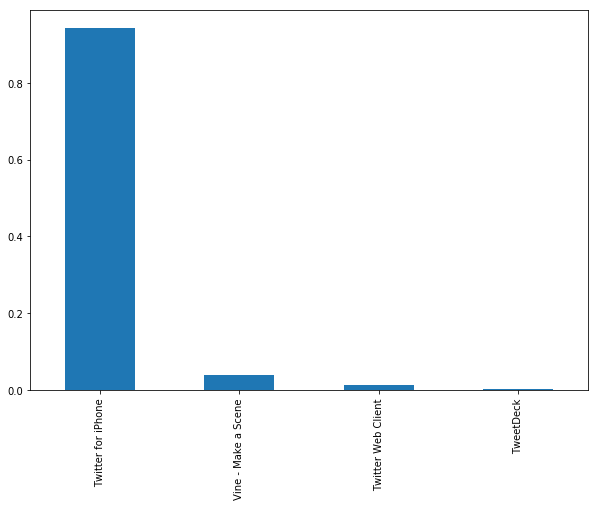

In [963]:
#Distribution of sources used to sent tweets
fig = plt.figure(figsize =(10, 7))
twitter_archive_master['source'].value_counts(normalize=True).plot(kind='bar',color=sns.color_palette()[0]);

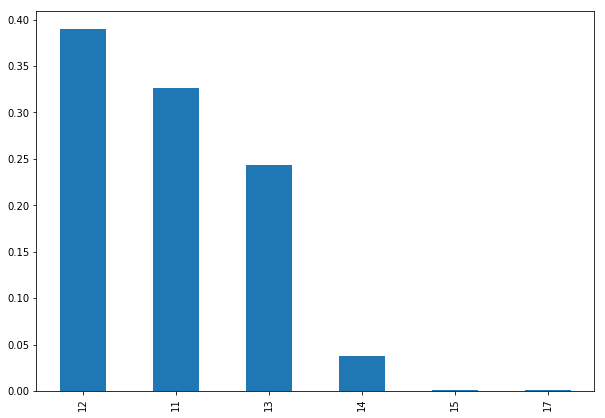

In [964]:
#bar plot of rating_numerator greater than 10 but less than 20
fig = plt.figure(figsize =(10, 7))
twitter_archive_master[(twitter_archive_master['rating_numerator'] > 10) & (twitter_archive_master['rating_numerator'] < 20)]['rating_numerator'].value_counts(normalize=True).plot(kind='bar',color=sns.color_palette()[0]);

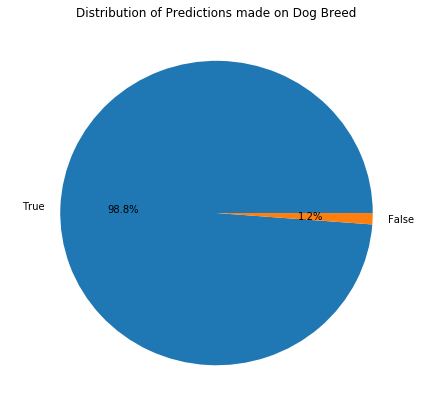

In [965]:
# pie chart of prediction1_dog
fig = plt.figure(figsize =(7, 7))
twitter_archive_master['prediction1_dog'].value_counts(normalize=True).plot(kind='pie',autopct='%1.1f%%');
plt.title('Distribution of Predictions made on Dog Breed')
plt.ylabel(' ');

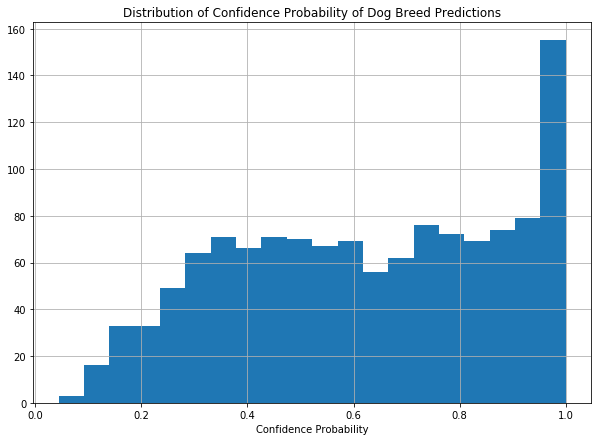

In [966]:
# univariate analysis of prediction1_conf,
fig = plt.figure(figsize =(10, 7))
twitter_archive_master['prediction1_conf'].hist(bins=20);
plt.title('Distribution of Confidence Probability of Dog Breed Predictions')
plt.xlabel('Confidence Probability');

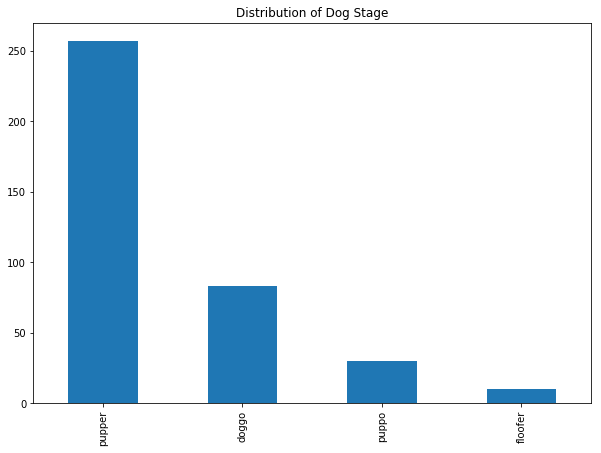

In [967]:
# univariate analysis of dog_stage
fig = plt.figure(figsize =(10, 7))
twitter_archive_master[twitter_archive_master['dog_stage'] !='None']['dog_stage'].value_counts().plot(kind='bar',color=sns.color_palette()[0])
plt.title('Distribution of Dog Stage');


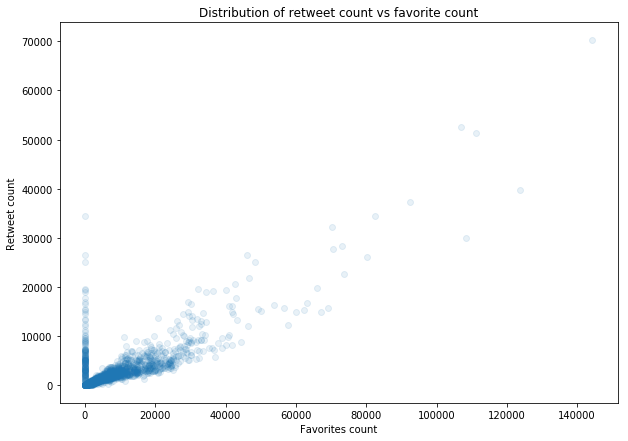

In [969]:
#scatter plot of retweet_count vs favorite_count
fig = plt.figure(figsize =(10, 7))
sns.regplot(data=twitter_archive_master,x='favorite_count',y='retweet_count',x_jitter=0.04, scatter_kws={'alpha':1/10}, fit_reg=False)
plt.title('Distribution of retweet count vs favorite count')
plt.ylabel('Retweet count')
plt.xlabel('Favorites count');

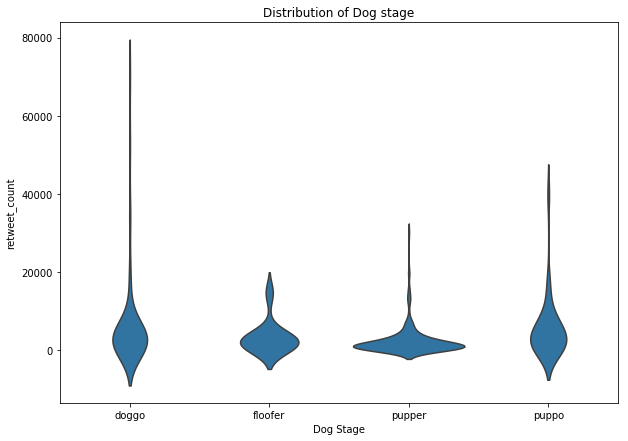

In [970]:
#violin plot of dog_stage
fig = plt.figure(figsize =(10, 7))
sns.violinplot(data=twitter_archive_master[twitter_archive_master['dog_stage'] !='None'],x='dog_stage',y='retweet_count',color=sns.color_palette()[0],inner=None)
plt.title('Distribution of Dog stage')
plt.xlabel('Dog Stage');

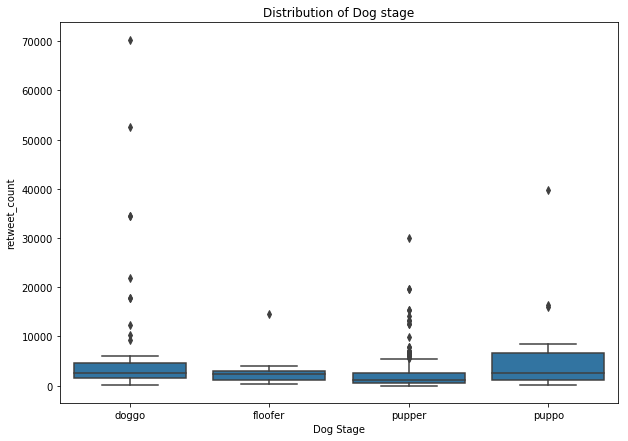

In [971]:
#boxplot of dog_stage
fig = plt.figure(figsize =(10, 7))
sns.boxplot(data=twitter_archive_master[twitter_archive_master['dog_stage'] !='None'],x='dog_stage',y='retweet_count',color=sns.color_palette()[0])
plt.title('Distribution of Dog stage');
plt.xlabel('Dog Stage');